# Dry Waste Classification Using Convolutional Neural Networks. 


---

---
 


#Preparing COLAB:

---

In [ ]:
#Checking CUDA version:
import subprocess
 
CUDA_version = [s for s in subprocess.check_output(["nvcc", "--version"]).decode("UTF-8").split(", ") if s.startswith("release")][0].split(" ")[-1]
print("CUDA version:", CUDA_version)
 
if CUDA_version == "10.0":
    torch_version_suffix = "+cu100"
elif CUDA_version == "10.1":
    torch_version_suffix = "+cu101"
elif CUDA_version == "10.2":
    torch_version_suffix = ""
else:
    torch_version_suffix = "+cu110"

CUDA version: 10.1


In [ ]:
#Imoorting PyTorch:
!pip install torch==1.7.1{torch_version_suffix} torchvision==0.8.2{torch_version_suffix} -f https://download.pytorch.org/whl/torch_stable.html ftfy regex
import torch
print("Torch version:", torch.__version__)

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 735.4MB 23kB/s 
     |████████████████████████████████| 12.8MB 251kB/s 
     |████████████████████████████████| 71kB 4.2MB/s 
  Created wheel for ftfy: filename=ftfy-5.8-cp36-none-any.whl size=45613 sha256=5a6e1c561bc432c91e14c6455374ec20e37eb2dbc0482362ee930ad36b1cc136
  Stored in directory: /root/.cache/pip/wheels/ba/c0/ef/f28c4da5ac84a4e06ac256ca9182fc34fa57fefffdbc68425b
Successfully built ftfy
  Found existing installation: torch 1.7.0+cu101
    Uninstalling torch-1.7.0+cu101:
      Successfully uninstalled torch-1.7.0+cu101
  Found existing installation: torchvision 0.8.1+cu101
    Uninstalling torchvision-0.8.1+cu101:
      Successfully uninstalled torchvision-0.8.1+cu101
Torch version: 1.7.1+cu101


In [ ]:
#Checking for GPU:
batch_size=512from torch import cuda
train_on_gpu = cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')
if train_on_gpu:
    gpu_count = cuda.device_count()
    print(f'{gpu_count} gpus detected.')
    if gpu_count > 1:
        multi_gpu = True
    else:
        multi_gpu = False

Train on gpu: True
1 gpus detected.


In [ ]:
#Initialising the Kaggle API
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

#Preparing Dataset:

---

In [ ]:
#Downloading dataset fom Kaggle:
!kaggle datasets download -d asdasdasasdas/garbage-classification

 95% 78.0M/82.0M [00:01<00:00, 36.2MB/s]
100% 82.0M/82.0M [00:01<00:00, 60.6MB/s]


In [ ]:
!unzip /content/garbage-classification.zip

In [346]:
#Making Data, Test, Train and Validation set directories:
import os
!mkdir data/
!rm -rf data/
!rm -rf data/train
!rm -rf data/test
!rm -rf data/val
!mkdir data/
!mkdir data/train
!mkdir data/test
!mkdir data/val

In [375]:
#Reading the Zero Indexed CSV file in order to acess the image paths. 
import pandas as pd 
df = pd.read_csv('/content/zero-indexed-files.txt', names=['FilePath', 'Target', 'Labels'])
df

,FilePath,Target,Labels
0,glass1.jpg 0,NaN,NaN
1,glass2.jpg 0,NaN,NaN
2,glass3.jpg 0,NaN,NaN
3,glass4.jpg 0,NaN,NaN
4,glass5.jpg 0,NaN,NaN
...,...,...,...
2522,trash133.jpg 5,NaN,NaN
2523,trash134.jpg 5,NaN,NaN
2524,trash135.jpg 5,NaN,NaN
2525,trash136.jpg 5,NaN,NaN


In [376]:
Names = ['glass', 'paper', 'cardboard', 'plastic', 'metal', 'trash']

In [377]:
n_classes = len(Names)
print('Number of classes:',n_classes)

Number of classes: 6


In [378]:
df['Target'] = df.FilePath.str[-1]
df['FilePath'] = df.FilePath.str[0:-1]
df['Labels'] = df['Target']

In [379]:
for i,row in df.iterrows():
  target = row['Target']
  row['Labels'] = Names[int(target)]

In [380]:
for i,row in df.iterrows():
  name = row['Labels']
  row['FilePath'] = '/content/Garbage classification/Garbage classification/' + name + '/' + row.FilePath

In [381]:
df['FilePath'] = df.FilePath.str[:-1]

In [382]:
#Splitting Dataset into Test, Train and Validation sets:
from sklearn.model_selection import train_test_split
X_train, X_test, _, _ = train_test_split(df, df['Labels'],stratify=df['Labels'], test_size=0.3)
X_test, X_val, _, _ = train_test_split(X_test, X_test['Labels'], stratify=X_test['Labels'], test_size=0.5)

In [ ]:
X_train['Type'] = 'train'
X_test['Type'] = 'test'
X_val['Type'] = 'val'
df = pd.concat([X_train,X_test, X_val])

In [384]:
df

,FilePath,Target,Labels,Type
5,/content/Garbage classification/Garbage classi...,0,glass,train
113,/content/Garbage classification/Garbage classi...,0,glass,train
2097,/content/Garbage classification/Garbage classi...,4,metal,train
300,/content/Garbage classification/Garbage classi...,0,glass,train
1662,/content/Garbage classification/Garbage classi...,3,plastic,train
...,...,...,...,...
1871,/content/Garbage classification/Garbage classi...,3,plastic,val
1169,/content/Garbage classification/Garbage classi...,2,cardboard,val
1879,/content/Garbage classification/Garbage classi...,3,plastic,val
936,/content/Garbage classification/Garbage classi...,1,paper,val


In [373]:
#Making subdirectories under Test, Train and Validation folders for each Class in the dataset:
for name in Names:
  os.system(f"mkdir data/train/'{name}'") 
  os.system(f"mkdir data/test/'{name}'")
  os.system(f"mkdir data/val/'{name}'")

In [386]:
#Copying files to folder 'data'
from shutil import copyfile
for i,row in df.iterrows():
    section = row['Type']
    ipath = row['FilePath']
    opath = ipath.replace(f"Garbage classification/Garbage classification/",f"data/{section}/")
    copyfile(ipath, opath)

In [390]:
traindir = '/content/data/train'
testdir = '/content/data/test'
valdir = '/content/data/val'

# Image Transformations:

--- 



In [391]:
#Defining Image Transformation:
from torchvision import transforms
image_transforms = {
    'train':
    transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(degrees=25),
        transforms.ColorJitter(),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]) 
    ]),

    'test':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),

    'val':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
} 

In [392]:
#Initialising Datasets:
from torchvision import datasets
data = {
    'train':
    datasets.ImageFolder(root=traindir, transform=image_transforms['train']),
    'test':
    datasets.ImageFolder(root=testdir, transform=image_transforms['test']),
    'val':
    datasets.ImageFolder(root=testdir, transform=image_transforms['val'])
} 

In [393]:
#Function to display Tensors:
def imshow_tensor(image, ax=None, title=None):

    if ax is None:
        fig, ax = plt.subplots()

    image = image.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)

    ax.imshow(image)
    plt.axis('off')

    return ax, image 

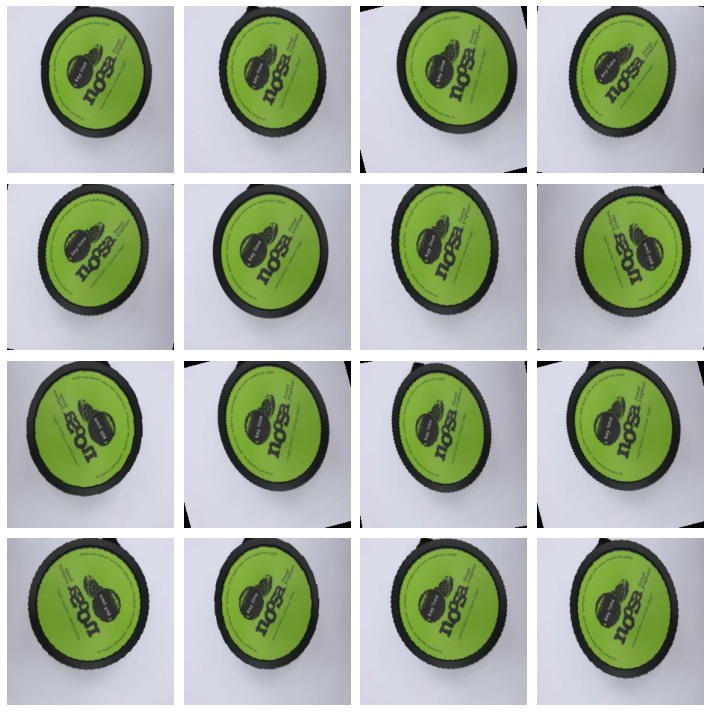

In [543]:
#Displaying Image Transform on an Image:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
ex_img = Image.open('/content/data/train/plastic/plastic307.jpg')
t = image_transforms['train']
plt.figure(figsize=(10,10))

for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    _ = imshow_tensor(t(ex_img), ax=ax)
plt.tight_layout()

#Setting Up Dataloaders:

---



In [397]:
#Setting up dataloaders:
from torch.utils.data import DataLoader
data = {
    'train':
    datasets.ImageFolder(root=traindir, transform=image_transforms['train']),
    'test':
    datasets.ImageFolder(root=testdir, transform=image_transforms['test']),
    'val':
    datasets.ImageFolder(root=testdir, transform=image_transforms['test'])
}

dataloaders = {
    'train': DataLoader(data['train'], batch_size=batch_size, shuffle=True,num_workers=10),
    'test': DataLoader(data['test'], batch_size=batch_size, shuffle=True,num_workers=10),
    'val': DataLoader(data['test'], batch_size=batch_size, shuffle=True,num_workers=10)
} 

In [398]:
#Running one iteration through dataloaders
trainiter = iter(dataloaders['train'])
features, labels = next(trainiter)
features.shape, labels.shape 

(torch.Size([512, 3, 224, 224]), torch.Size([512]))

#Model: ResNet50

In [399]:
#Importing model:
rom torchvision import models
model = models.resnet50(pretrained=True)

In [400]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [401]:
#Freezing weights:
for param in model.parameters():
    param.requires_grad = False 

In [402]:
#Defining custom classifier:
import torch.nn as nn
n_inputs = model.fc.in_features
model.fc = nn.Sequential(
                      nn.Linear(n_inputs, 256),
                      nn.ReLU(),
                      nn.Dropout(0.4),
                      nn.Linear(256, n_classes),
                      nn.LogSoftmax(dim=1))

In [403]:
model.fc 

Sequential(
  (0): Linear(in_features=2048, out_features=256, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.4, inplace=False)
  (3): Linear(in_features=256, out_features=6, bias=True)
  (4): LogSoftmax(dim=1)
)

In [404]:
#Loading model to GPU:
if train_on_gpu:
    model = model.to('cuda') 

In [405]:
model.class_to_idx = data['train'].class_to_idx
model.idx_to_class = {
    idx: class_
    for class_, idx in model.class_to_idx.items()
}

list(model.idx_to_class.items())[:10] 

[(0, 'cardboard'),
 (1, 'glass'),
 (2, 'metal'),
 (3, 'paper'),
 (4, 'plastic'),
 (5, 'trash')]

In [406]:
#Defining Criterion and Optimizer:
from torch import optim
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters())
for p in optimizer.param_groups[0]['params']:
    if p.requires_grad:
        print(p.shape) 

torch.Size([256, 2048])
torch.Size([256])
torch.Size([6, 256])
torch.Size([6])


# Training Model:

In [461]:
#Function to train Model:
from timeit import default_timer as timer
def train(model,criterion,optimizer,train_loader, valid_loader, n_epochs=20, print_every=1):
  history = []

  for epoch in range(n_epochs):
    train_loss = 0.0
    train_acc = 0
    valid_loss = 0.0
    valid_acc = 0

    model.train()
    start = timer()

    for i, (data, target) in enumerate(train_loader):
      if train_on_gpu: 
        data, target = data.cuda(), target.cuda()
      optimizer.zero_grad()
      output = model(data)
      loss = criterion(output, target)
      loss.backward()
      optimizer.step()
      train_loss += loss.item() * data.size(0)
      _, pred = torch.max(output, dim=1)
      correct_tensor = pred.eq(target.data.view_as(pred))
      accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
      train_acc += accuracy.item() * data.size(0)
    
    else:
      with torch.no_grad():
        model.eval()
        for data, target in valid_loader:
          if train_on_gpu:
            data, target = data.cuda(), target.cuda()
          output = model(data)
          loss = criterion(output, target)
          valid_loss += loss.item()*data.size(0)
          _, pred = torch.max(output, dim=1)
          correct_tensor = pred.eq(target.data.view_as(pred))
          accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
          valid_acc += accuracy.item()*data.size(0)

  train_loss = train_loss / len(train_loader.dataset)
  train_acc = train_acc / len(train_loader.dataset)
  valid_loss = valid_loss / len(valid_loader.dataset)
  valid_acc = valid_acc / len(valid_loader.dataset)
  history.append([train_loss, train_acc, valid_loss, valid_acc])

  model.optimizer = optimizer
  total_time = timer() 
  history = pd.DataFrame(history,columns=['Train_loss', 'Train_acc', 'Val_loss', 'Val_ac'])

  return model, history

In [546]:
#Training model:
model, history = train(model, criterion, optimizer, dataloaders['train'], dataloaders['val'], n_epochs=150)

In [547]:
#Performance metircs:
history 

,Train_loss,Train_acc,Val_loss,Val_ac
0,0.018312,0.995475,0.58596,0.886544


#Predictions on a single image:



In [548]:
#Function to process an Image path into a Tensor:
def process_image(image_path):

    image = Image.open(image_path)
    img = image.resize((256, 256))

    width = 256
    height = 256
    new_width = 224
    new_height = 224

    left = (width - new_width) / 2
    top = (height - new_height) / 2
    right = (width + new_width) / 2
    bottom = (height + new_height) / 2
    img = img.crop((left, top, right, bottom))
    img = np.array(img).transpose((2, 0, 1)) / 256
    means = np.array([0.485, 0.456, 0.406]).reshape((3, 1, 1))
    stds = np.array([0.229, 0.224, 0.225]).reshape((3, 1, 1))

    img = img - means
    img = img / stds

    img_tensor = torch.Tensor(img)

    return img_tensor

In [549]:
#Making predictions on a single Image:
def predict(image_path, model, topk=3):
    real_class = image_path.split('/')[-2]

    img_tensor = process_image(image_path)

    if train_on_gpu:
        img_tensor = img_tensor.view(1, 3, 224, 224).cuda()
    else:
        img_tensor = img_tensor.view(1, 3, 224, 224)

    with torch.no_grad():
        model.eval()
        out = model(img_tensor)
        ps = torch.exp(out)

        #Top 3 predictions
        topk, topclass = ps.topk(topk, dim=1)
        top_classes = [
            model.idx_to_class[class_] for class_ in topclass.cpu().numpy()[0]
        ]
        top_p = topk.cpu().numpy()[0]

        return img_tensor.cpu().squeeze(), top_p, top_classes, real_class

In [562]:
img_path = '/content/data/test/metal/metal185.jpg'
img, top_p, top_classes, real_class = predict(img_path, model,topk=3)

In [563]:
top_p, top_classes

(array([9.9996638e-01, 3.2385495e-05, 1.1395507e-06], dtype=float32),
 ['metal', 'glass', 'paper'])

In [564]:
#Function to display Image and Predictions:
def display_prediction(image_path, model, topk):
    img, ps, classes, y_obs = predict(image_path, model, topk)
    result = pd.DataFrame({'p': ps}, index=classes)
    plt.figure(figsize=(16, 5))
    ax = plt.subplot(1, 2, 1)
    ax, img = imshow_tensor(img, ax=ax)
    ax.set_title(y_obs, size=20)

    ax = plt.subplot(1, 2, 2)
    #Bar plot
    result.sort_values('p')['p'].plot.barh(color='#2e4d7d', edgecolor='k', ax=ax)
    plt.xlabel('Predicted Probability')
    plt.tight_layout()

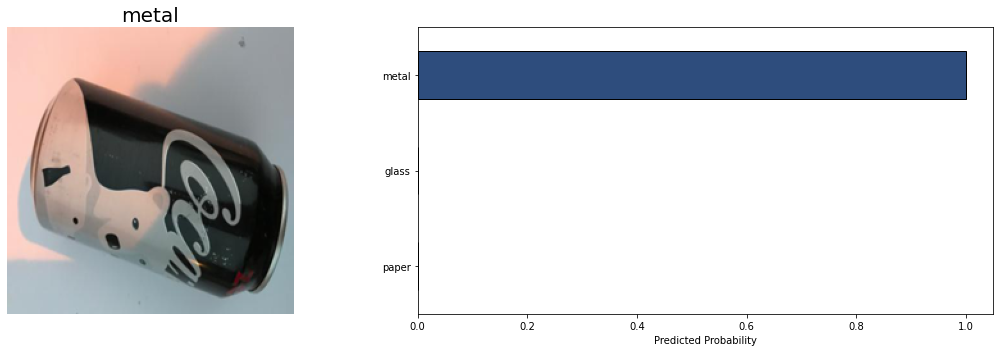

In [565]:
display_prediction(img_path, model, topk=3)

#Evaluation of model and results:

In [566]:
#Function to calculate accuracy of Top N predictions:
def accuracy(output, target, topk=(1, )):
    if train_on_gpu:
        output = output.to('cuda')
        target = target.to('cuda')

    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)
        _, pred = output.topk(k=maxk, dim=1, largest=True, sorted=True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size).item())
        return res

In [568]:
#Function to evaluate model: 
def evaluate(model, test_loader, criterion, topk=(1, 2, 3)):
    confusion_matrix = torch.zeros(n_classes, n_classes)
    classes = []
    losses = []
    acc_results = np.zeros((len(test_loader.dataset), len(topk)))
    i = 0

    model.eval()
    with torch.no_grad():
        for data, targets in test_loader:
            if train_on_gpu:
                data, targets = data.to('cuda'), targets.to('cuda')

            out = model(data)
            _, predscm = torch.max(out, 1)
            for t, p in zip(targets.view(-1), predscm.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
          
            for pred, true in zip(out, targets):
                acc_results[i, :] = accuracy(
                    pred.unsqueeze(0), true.unsqueeze(0), topk)
                classes.append(model.idx_to_class[true.item()])
                loss = criterion(pred.view(1, n_classes), true.view(1))
                losses.append(loss.item())
                i += 1

    results = pd.DataFrame(acc_results, columns=[f'top{i}' for i in topk])
    results['class'] = classes
    results['loss'] = losses
    results = results.groupby(classes).mean()

    return results.reset_index().rename(columns={'index': 'class'}),confusion_matrix

criterion = nn.NLLLoss()

In [569]:
#Function to display Confusion Matrix:
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else '.0f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return plt 

In [570]:
results, confusion_matrix = evaluate(model, dataloaders['test'], criterion)

Confusion matrix, without normalization


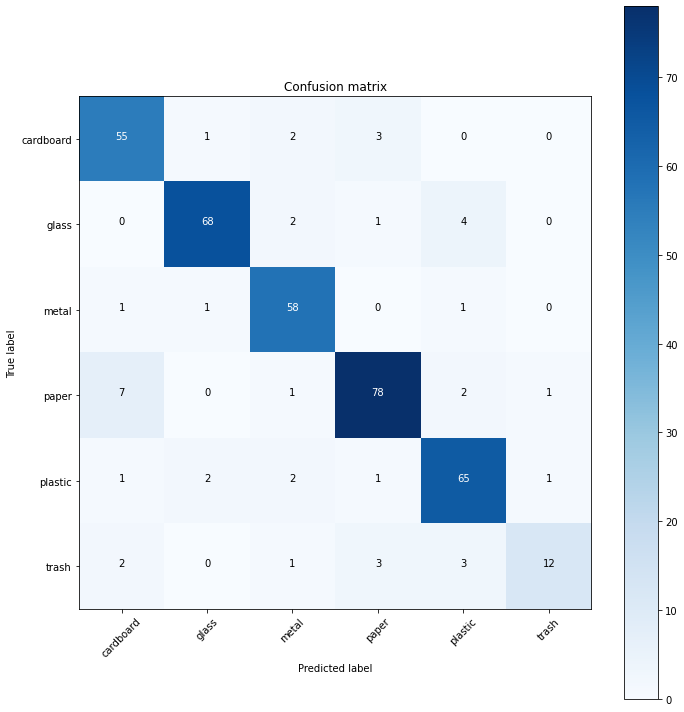

In [571]:
classnames = [model.idx_to_class[i] for i in range(0,n_classes)]
plt.figure(figsize=(10,10))
plt = plot_confusion_matrix(confusion_matrix, classnames)

In [572]:
#Results per class:
results

,class,top1,top2,top3,loss
0,cardboard,90.163934,100.000000,100.000000,0.214906
1,glass,90.666667,98.666667,100.000000,0.387513
2,metal,95.081967,98.360656,98.360656,0.398931
3,paper,87.640449,96.629213,97.752809,0.644695
4,plastic,90.277778,94.444444,95.833333,0.580316
5,trash,57.142857,76.190476,85.714286,2.686231


In [573]:
#Overall Accuracy:
print(f"Overall Accuracy:{(confusion_matrix.diag().sum()/confusion_matrix.sum())*100}%")

Overall Accuracy:88.65435028076172%
